In [127]:
import os
import sys

import torch
from pathlib import Path
import yaml
from torch_geometric.datasets import WikiCS

In [128]:
dataset_path = Path(os.getcwd()).resolve().parent / "data" / "WikiCS"
dataset = WikiCS(root=dataset_path)
original_data = dataset[0]
original_data.x.shape

/home/witcher/jakub/ure/representation_clustering/.venv/lib/python3.12/site-packages/torch_geometric/datasets/wikics.py:45: UserWarning: The WikiCS dataset now returns an undirected graph by default. Please explicitly specify 'is_undirected=False' to restore the old behavior.
  warnings.warn(


torch.Size([11701, 300])

In [ ]:
embedings_path = Path(os.getcwd()).resolve().parent / "data" / "embeddings" / "node_embeddings_gca_128_1.0.pt"
with open(embedings_path, 'rb') as f:
    node_embedings = torch.load(f)

node_embedings = node_embedings.numpy()
node_embedings.shape

(11701, 128)

In [130]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

def pca_visaulise(nd_features, nd_embedings):
    f_pca = PCA(n_components=2)
    f_2d = StandardScaler().fit_transform(nd_features.x.numpy())
    f_2d = f_pca.fit_transform(f_2d)

    e_pca = PCA(n_components=2)
    e_2d = StandardScaler().fit_transform(nd_embedings)
    e_2d = e_pca.fit_transform(e_2d)

    df_f_pca = pd.DataFrame({'PCA1': f_2d[:, 0], 'PCA2': f_2d[:, 1], 'label': nd_features.y.numpy()})
    df_e_pca = pd.DataFrame({'PCA1': e_2d[:, 0], 'PCA2': e_2d[:, 1], 'label': nd_features.y.numpy()})
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=df_f_pca, palette='tab10', alpha=0.8, ax=ax[0])
    ax[0].set_title(f"Node features (explained variance: {f_pca.explained_variance_ratio_.cumsum()[-1] * 100:.3f}%)")
    sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=df_e_pca, palette='tab10', alpha=0.8, ax=ax[1])
    ax[1].set_title(f"Node embedings (explained variance: {e_pca.explained_variance_ratio_.cumsum()[-1] * 100:.3f}%)")
    fig.tight_layout()
    plt.show()

def run_test_for_one_split(xs, ys, train_mask, test_mask):
    tester = Pipeline([
        ('scaler', StandardScaler()), 
        ('estimator', LogisticRegression(max_iter=1000))
    ])
    tester.fit(xs[train_mask], ys[train_mask])
    y_train_pred = tester.predict(xs[train_mask])
    y_test_pred = tester.predict(xs[test_mask])
    return {
        'train_acc': accuracy_score(y_true=ys[train_mask], y_pred=y_train_pred),
        'test_acc': accuracy_score(y_true=ys[test_mask], y_pred=y_test_pred),
        'train_auc': roc_auc_score(y_true=ys[train_mask], y_score=tester.predict_proba(xs[train_mask]), multi_class='ovr'),
        'test_auc': roc_auc_score(y_true=ys[test_mask], y_score=tester.predict_proba(xs[test_mask]), multi_class='ovr'),
    }

def classification_test(nd_features, nd_embedings):
    results_features = []
    results_embedings = []
    for split_id in range(20):
        results_features.append(run_test_for_one_split(nd_features.x, nd_features.y, nd_features.train_mask[:, split_id], nd_features.test_mask))
        results_embedings.append(run_test_for_one_split(nd_embedings, nd_features.y, nd_features.train_mask[:, split_id], nd_features.test_mask))

    df_features = pd.DataFrame(results_features)
    df_embedings = pd.DataFrame(results_embedings)
    return (df_features, df_embedings)

def class_histogram(nd_features):
    fig, ax = plt.subplots()
    sns.histplot(nd_features.y, bins=len(torch.unique(nd_features.y)), discrete=True)
    plt.xticks(torch.unique(nd_features.y))
    ax.set_xticklabels(torch.unique(nd_features.y).numpy())
    plt.title("Class histogram")
    plt.show()


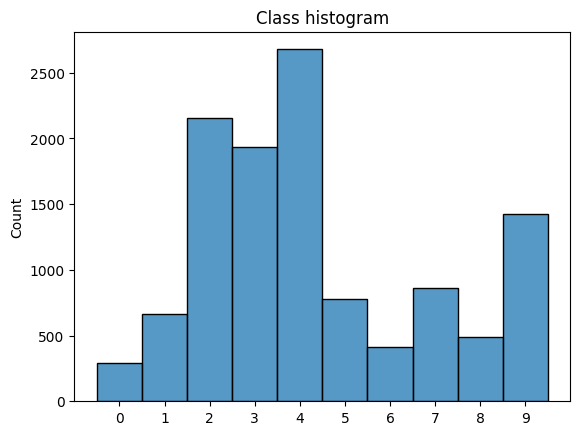

In [132]:
class_histogram(original_data)

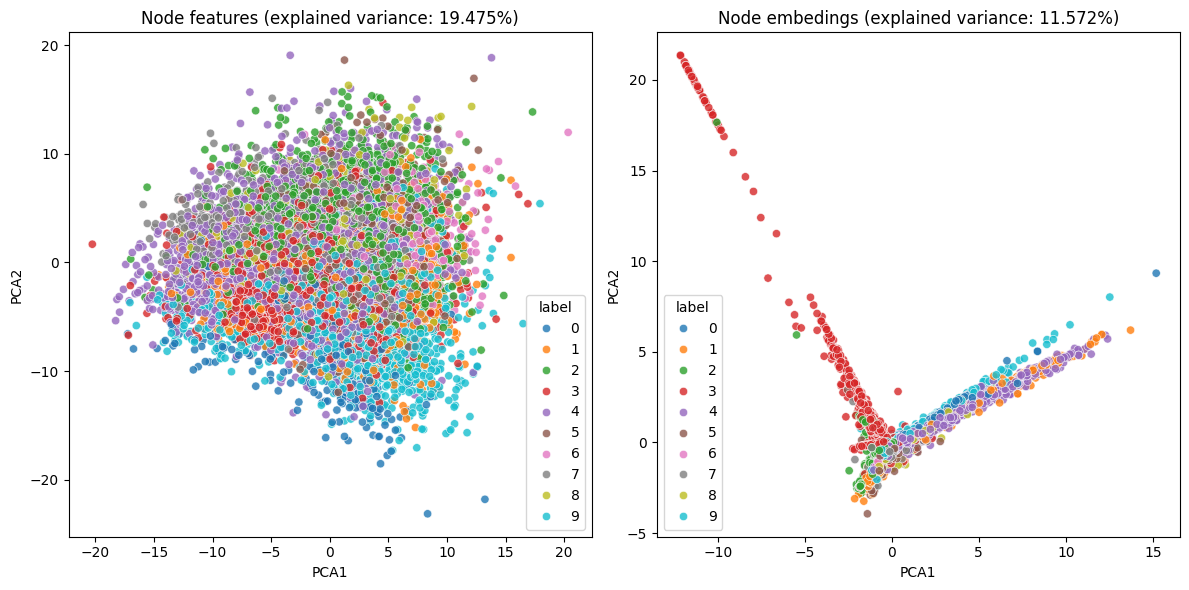

In [133]:
pca_visaulise(original_data, node_embedings)

In [134]:
df_features, df_embeddings = classification_test(original_data, node_embedings)

In [135]:
df_embeddings.mean()

train_acc    0.849397
test_acc     0.742022
train_auc    0.987593
test_auc     0.938234
dtype: float64

In [136]:
df_features.mean()

train_acc    1.000000
test_acc     0.704977
train_auc    1.000000
test_auc     0.944231
dtype: float64